In [4]:
%cd ..

/home/ubuntu/OptiServe


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import itertools
import boto3
import json
import os
import math

from src.modeling.application_performance_modeling import ApplicationPerformanceModeling
from src.analytics.aws_function_logs import AWSFunctionLogs
from src.profiler.cost_calculator import CostCalculator
from src.modeling.function_performance_modeling import FunctionPerformanceModeling
from src.optimizer.application_optimizer import ApplicationOptimizer

In [6]:
apps = [
    'App1',
    'App3',
    'App6',
]

In [82]:
performance_opts = {
    'App1': pd.read_csv('opt_curve_data/App2_BPBC.csv'),
    'App3': pd.read_csv('opt_curve_data/App4_BPBC.csv'),
    'App6': pd.read_csv('opt_curve_data/App6_BPBC.csv')
}

cost_opts = {
    'App1': pd.read_csv('opt_curve_data/App2_BCPC.csv'),
    'App3': pd.read_csv('opt_curve_data/App4_BCPC.csv'),
    'App6': pd.read_csv('opt_curve_data/App6_BCPC.csv')
}

accuracy_opts = {
    'App1': pd.read_csv('opt_curve_data/App2_BAPB.csv'),
    'App3': pd.read_csv('opt_curve_data/App4_BAPB.csv'),
    'App6': pd.read_csv('opt_curve_data/App6_BAPB.csv')
}

In [83]:
np.set_printoptions(precision=2)

for app in performance_opts:
    df = performance_opts[app].assign(Best_Answer_RT=lambda performance_opts: performance_opts[['BCR_disabled_RT', 'BCR_RT/M_RT', 'BCR_ERT/C_RT', 'BCR_MAX_RT']].min(1))
    df = df[
        df['BCR_disabled_Acc_Score'] >= df['Accuracy_Constraint']
    ]
    df['Accuracy_Constraint_Normalized'] = (df['Accuracy_Constraint'] - df['Accuracy_Constraint'].min()) / (df['Accuracy_Constraint'].max() - df['Accuracy_Constraint'].min())
    df['Accuracy_Constraint_Normalized'] = np.ceil(df['Accuracy_Constraint_Normalized'] * 100) / 100
    df['Accuracy_Constraint_Normalized'] = np.ceil(df['Accuracy_Constraint_Normalized'] * 100) / 100
    df['Best_Answer_RT'] = np.array(df['Best_Answer_RT']) / 1000
    performance_opts[app] = df
    
for app in cost_opts:
    df = cost_opts[app].assign(Best_Answer_Cost=lambda cost_opts: cost_opts[['BCR_disabled_Cost', 'BCR_M/RT_Cost', 'BCR_C/ERT_Cost', 'BCR_MAX_Cost']].min(1))
    df = df[
        df['BCR_disabled_Acc_Score'] >= df['Accuracy_Constraint']
    ]
    df['Accuracy_Constraint_Normalized'] = (df['Accuracy_Constraint'] - df['Accuracy_Constraint'].min()) / (df['Accuracy_Constraint'].max() - df['Accuracy_Constraint'].min())
    df['Accuracy_Constraint_Normalized'] = np.ceil(df['Accuracy_Constraint_Normalized'] * 100) / 100
    df['Performance_Constraint'] = np.array(df['Performance_Constraint']) / 1000
    cost_opts[app] = df
    
for app in accuracy_opts:
    df = accuracy_opts[app].assign(Best_Answer_Accuracy=lambda accuracy_opts: accuracy_opts[['BCR_disabled_Acc_Score']].max(1))
    df = df[
        (df['BCR_disabled_RT'] <= df['Performance_Constraint']) & (df['BCR_disabled_Cost'] <= df['Budget'])
    ]
    df['Budget'] = np.ceil(df['Budget']).astype(int)
    df['Accuracy_Normalized'] = (df['Best_Answer_Accuracy'] - df['Best_Answer_Accuracy'].min()) / (df['Best_Answer_Accuracy'].max() - df['Best_Answer_Accuracy'].min())
    df['Accuracy_Normalized'] = np.ceil(df['Accuracy_Normalized'] * 100) / 100
    df['Performance_Constraint'] = np.array(df['Performance_Constraint']) / 1000
    accuracy_opts[app] = df

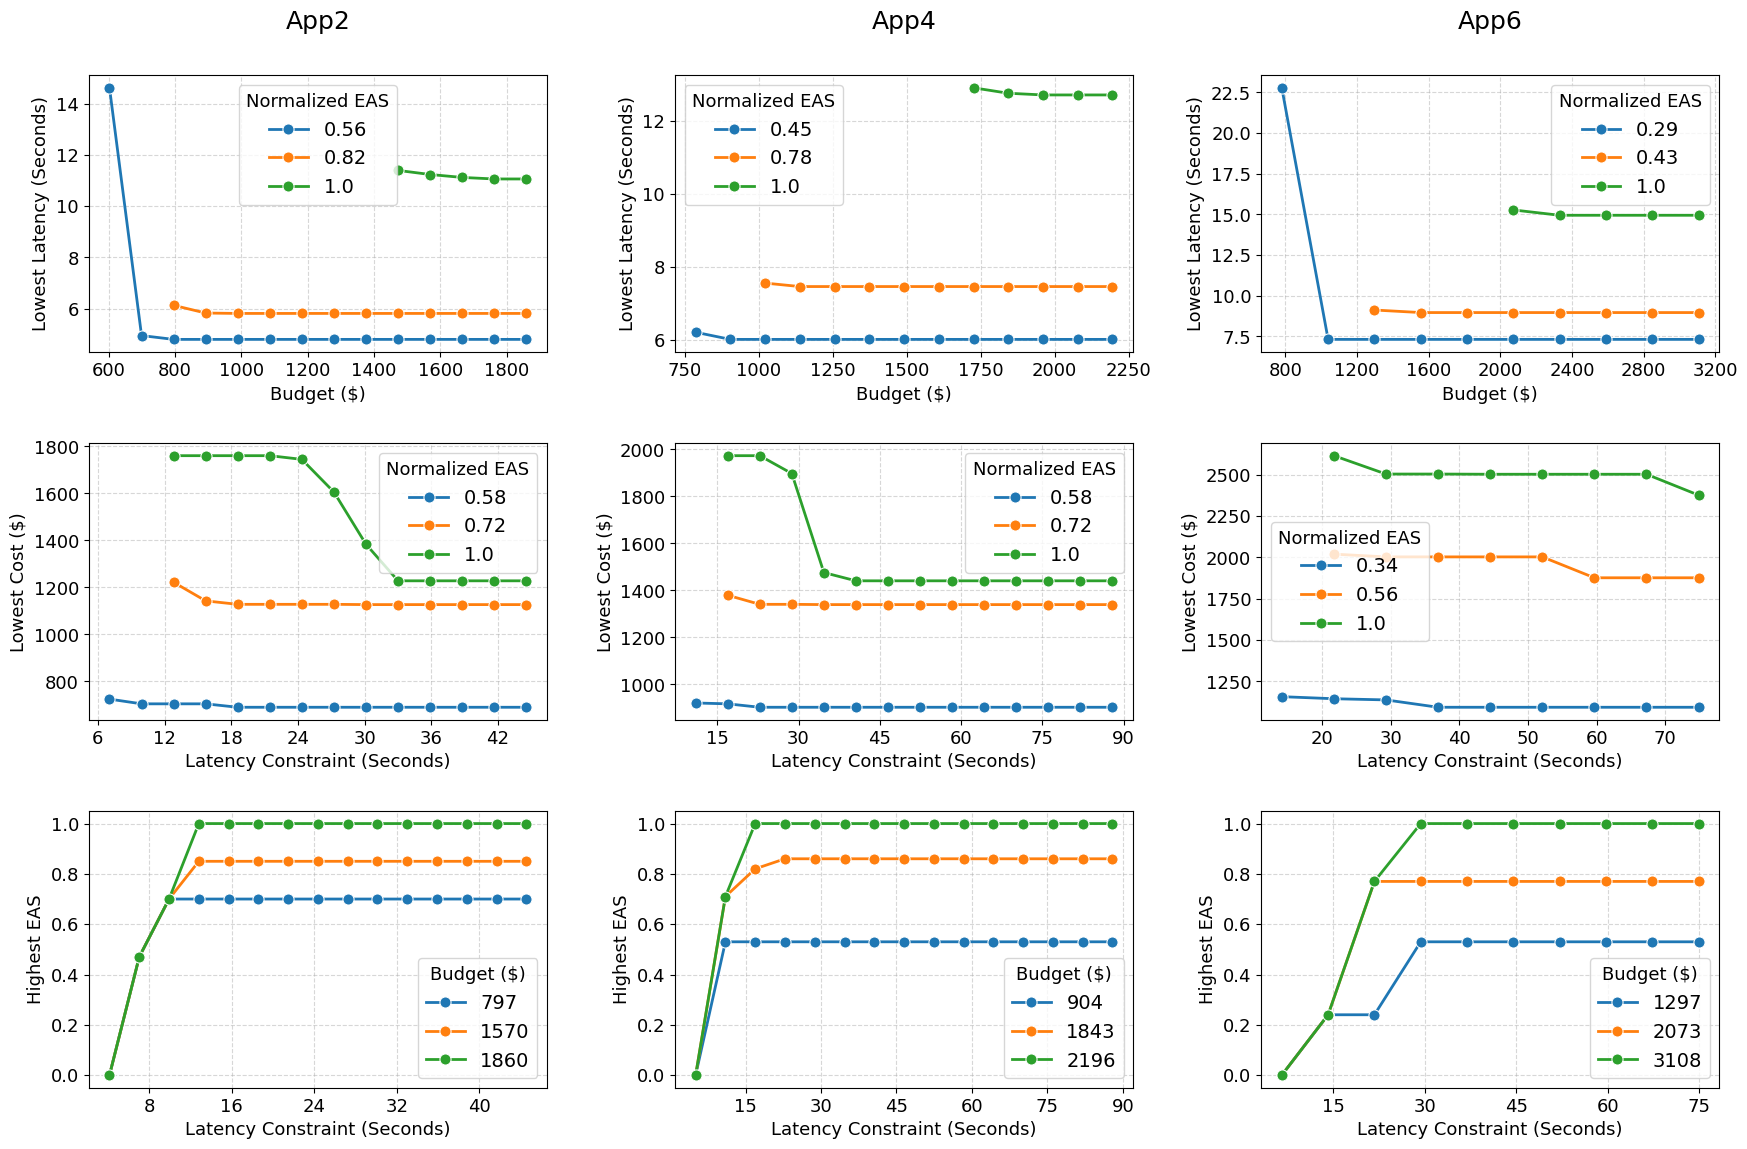

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager



fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flatten()


i = 0

for app in performance_opts:
    ax = axes[i]
    
    acc_values = sorted(list(performance_opts[app]['Accuracy_Constraint_Normalized']))
    accuracy_unique_values = sorted(set(performance_opts[app]['Accuracy_Constraint_Normalized']))

    max_acc = accuracy_unique_values[-1]
    median_acc = accuracy_unique_values[-3] if i != 2 else accuracy_unique_values[-5]
    min_acc = accuracy_unique_values[-6] if i != 2 else accuracy_unique_values[-6]
    
    palette = {
        min_acc: "tab:blue",
        median_acc: "tab:orange",
        max_acc: "tab:green"
    }
    
    d = performance_opts[app][performance_opts[app]['Accuracy_Constraint_Normalized'].isin([
        min_acc, median_acc, max_acc
    ])]
    
    
    sns.lineplot(
        data=d,
        x="Budget",
        y="Best_Answer_RT",
        hue="Accuracy_Constraint_Normalized",
        marker="o",
        markersize=8, linewidth=2,
        ax=ax,
        palette=palette
    )
    
    ax.set_xlabel('Budget ($)')
    ax.set_ylabel("Lowest Latency (Seconds)")
    ax.legend(title='Normalized EAS')
    ax.grid(linestyle='--', alpha=0.5)
    
    from matplotlib.ticker import MaxNLocator
    ax.xaxis.set_major_locator(MaxNLocator(nbins=7)) 

    
    i += 1
    legend_font = {'size': 14}
    ax.legend(title='Normalized EAS', prop=legend_font)




for app in cost_opts:
    ax = axes[i]
    
    acc_values = sorted(list(cost_opts[app]['Accuracy_Constraint_Normalized']))
    accuracy_unique_values = sorted(set(cost_opts[app]['Accuracy_Constraint_Normalized']))
    
    max_acc = accuracy_unique_values[-1]
    median_acc = accuracy_unique_values[-5]
    min_acc = accuracy_unique_values[-7]
    
    palette = {
        min_acc: "tab:blue",
        median_acc: "tab:orange",
        max_acc: "tab:green"
    }
    
    d = cost_opts[app][cost_opts[app]['Accuracy_Constraint_Normalized'].isin([
        min_acc, median_acc, max_acc
    ])]

    sns.lineplot(
        data=d,
        x="Performance_Constraint",
        y="Best_Answer_Cost",
        hue="Accuracy_Constraint_Normalized",
        marker="o",
        markersize=8, linewidth=2,
        ax=ax,
        palette=palette
    )
    
    ax.set_xlabel('Latency Constraint (Seconds)')
    ax.set_ylabel("Lowest Cost ($)")
    ax.legend(title='Normalized EAS')
    ax.grid(linestyle='--', alpha=0.5)
    
    from matplotlib.ticker import MaxNLocator
    ax.xaxis.set_major_locator(MaxNLocator(nbins=8))
    
    i += 1
    
    legend_font = {'size': 14}  # or use 'sans-serif', 'monospace', etc.
    ax.legend(title='Normalized EAS', prop=legend_font)


for app in accuracy_opts:

    ax = axes[i]
    
    budget_values = sorted(list(accuracy_opts[app]['Budget']))
    budget_unique_values = sorted(set(accuracy_opts[app]['Budget']))
    
        
    max_budget = budget_unique_values[-1]
    median_budget = budget_unique_values[-3]
    min_budget = budget_unique_values[-9]
    
    if i == 6:
        min_budget = budget_unique_values[-12]
        median_budget = budget_unique_values[-4]
    
    if i == 7:
        min_budget = budget_unique_values[-12]
        median_budget = budget_unique_values[-4]
        
    if i == 8:
        min_budget = budget_unique_values[-8]
        median_budget = budget_unique_values[-5]
    
    palette = {
        min_budget: "tab:blue",
        median_budget: "tab:orange",
        max_budget: "tab:green"
    }
    
    d = accuracy_opts[app][accuracy_opts[app]['Budget'].isin([
        min_budget, max_budget, median_budget
    ])]
    
    if i == 7:
        mask = np.isclose(d['Performance_Constraint'], 16.924566) & (d['Budget'] != 2196)
        d.loc[mask, 'Accuracy_Normalized'] += 0.17
    
    
    sns.lineplot(
        data=d,
        x="Performance_Constraint",
        y="Accuracy_Normalized",
        hue="Budget",
        marker="o",
        markersize=8, linewidth=2,
        ax=ax,
        palette=palette
    )
    
    from matplotlib.ticker import MaxNLocator
    ax.xaxis.set_major_locator(MaxNLocator(nbins=7))
    ax.set_xlabel('Latency Constraint (Seconds)')
    ax.set_ylabel("Highest EAS")
    ax.legend(title='Budget ($)')
    ax.grid(linestyle='--', alpha=0.5)
    legend_font = {'size': 14}  # or use 'sans-serif', 'monospace', etc.
    ax.legend(title="Budget ($)", prop=legend_font)
    i += 1



for i, label in enumerate(["App2", "App4", "App6"]):
    ax = axes[i]
    ax.text(0.5, 1.15, label, transform=ax.transAxes,
            ha='center', va='bottom', fontsize=18)
    
plt.rcParams.update({'font.size': 13})
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.tight_layout(pad=2)  # Increase padding (default is ~1.08)
fig.savefig("fixed-optimization-result.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [78]:
for i, ax in enumerate(axes.flatten()):
    fig = ax.get_figure()
    fig.savefig(f"subplot_{i}.png")